# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

In [3]:
os.chdir("/content/drive/MyDrive/AY21_22/2021/BT4221/BT4221 Project/Processing   Model /Data")

# Import Packages Required

In [4]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from numpy.random import seed
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Softmax, Dropout
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow
import pandas as pd

%matplotlib inline
from glob import glob

In [5]:
# Set seed
seed(1)
tensorflow.random.set_seed(2)

# Function

In [6]:
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

# VGG Set Up

In [7]:
img_size = [224, 224]
baseModel = VGG16(input_shape = img_size + [3], weights='imagenet', include_top=False)
for layer in baseModel.layers:
    layer.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


# Small Sample Size (5%)

## Processing

In [ ]:
train_path = "/content/drive/MyDrive/AY21_22/2021/BT4221/BT4221 Project/Processing   Model /Data/unique_5_sample_train"
test_path = "/content/drive/MyDrive/AY21_22/2021/BT4221/BT4221 Project/Processing   Model /Data/unique_5_sample_test"

In [ ]:
path = train_path
diag_code_dict = {
    'COVID19': 0,
    'NORMAL': 1,
    'PNEUMONIA': 2}

diag_title_dict = {
    'COVID19': 'Covid-19',
    'NORMAL': 'Healthy',
    'PNEUMONIA': 'Pneumonia'}

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}

imageid_path_dict

{}

In [ ]:
classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)

img_size = [224, 224]
train_datagen = ImageDataGenerator(rescale = 1./224)

test_datagen = ImageDataGenerator(rescale = 1./224)

train_generator = train_datagen.flow_from_directory(directory = train_path,
                                                        target_size = tuple(img_size),
                                                        batch_size = 8,
                                                        shuffle = True,
                                                        class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(directory = test_path,
                                                        target_size = tuple(img_size),
                                                        batch_size = 1,
                                                        class_mode = 'categorical',
                                                        shuffle = False)

Found 300 images belonging to 3 classes.
Found 62 images belonging to 3 classes.


In [ ]:
num_pneumonia = len(os.listdir(os.path.join(train_path, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_path, 'NORMAL')))
num_covid = len(os.listdir(os.path.join(train_path, 'COVID19')))

total = num_normal + num_pneumonia + num_covid
weight_for_0 = num_covid / total
weight_for_1 = num_normal / total
weight_for_2 = num_pneumonia / total
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

## Model 1

In [ ]:
model =  MaxPooling2D(pool_size = (2, 2), 
                               strides = 1, padding = 'valid')(baseModel.output)
model = Flatten()(model)

model = Dense(units = 256, activation = 'relu')(model)
model = Dense(units = 128, activation = 'relu')(model)
model = Dense(units = 64, activation = 'relu')(model)


# Stick with 3 because 3 different classes to be predicted
predictions = Dense(units = 3, activation = 'softmax')(model)
model = Model(inputs = baseModel.input, outputs = predictions)

opt = Adam(learning_rate=0.001, decay=1e-6)
model.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15)
CheckPointCallback = ModelCheckpoint("vgg_5size.h5", monitor='val_accuracy',save_best_only=True, mode='max',verbose=1)

seed(1)
tensorflow.random.set_seed(2)

history = model.fit(train_generator,
                    epochs = 25,
                    batch_size = 16,
                    validation_data= test_generator,
                    class_weight = class_weight,
                    callbacks = [CheckPointCallback],
                    verbose = 1)

Epoch 1/25
38/38 [==============================] - 12s 293ms/step - loss: 0.4280 - accuracy: 0.6667 - val_loss: 0.2414 - val_accuracy: 0.8548

Epoch 00001: val_accuracy improved from -inf to 0.85484, saving model to vgg_5size.h5
Epoch 2/25
38/38 [==============================] - 11s 292ms/step - loss: 0.0775 - accuracy: 0.8867 - val_loss: 0.4468 - val_accuracy: 0.8065

Epoch 00002: val_accuracy did not improve from 0.85484
Epoch 3/25
38/38 [==============================] - 11s 278ms/step - loss: 0.1837 - accuracy: 0.8533 - val_loss: 0.1183 - val_accuracy: 0.9516

Epoch 00003: val_accuracy improved from 0.85484 to 0.95161, saving model to vgg_5size.h5
Epoch 4/25
38/38 [==============================] - 11s 289ms/step - loss: 0.0562 - accuracy: 0.9233 - val_loss: 0.0702 - val_accuracy: 0.9839

Epoch 00004: val_accuracy improved from 0.95161 to 0.98387, saving model to vgg_5size.h5
Epoch 5/25
38/38 [==============================] - 11s 296ms/step - loss: 0.0115 - accuracy: 0.9833 - va

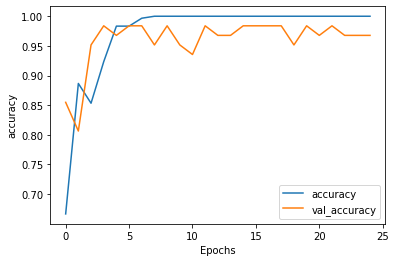

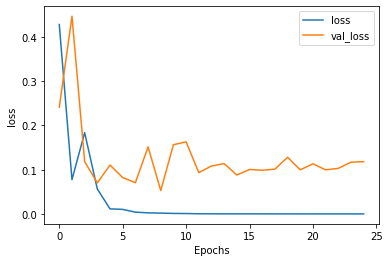

In [ ]:
plotting(history, "accuracy")
plotting(history, "loss")

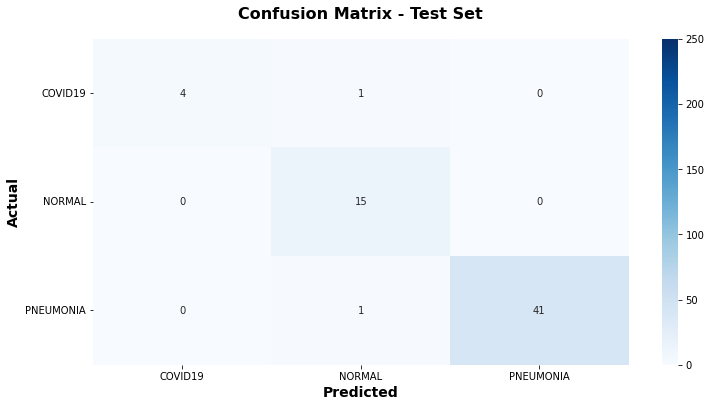

In [ ]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

62/62 [==============================] - 3s 42ms/step - loss: 0.1182 - accuracy: 0.9677
Test Accuracy: 96.77%
38/38 [==============================] - 8s 215ms/step - loss: 2.6597e-04 - accuracy: 1.0000
Train Accuracy: 100.00%


# Medium Sample Size (20%)

## Processing

In [8]:
train_path = "/content/drive/MyDrive/AY21_22/2021/BT4221/BT4221 Project/Processing   Model /Data/unique_20_sample_train"
test_path = "/content/drive/MyDrive/AY21_22/2021/BT4221/BT4221 Project/Processing   Model /Data/unique_20_sample_test"

In [9]:
path = train_path
diag_code_dict = {
    'COVID19': 0,
    'NORMAL': 1,
    'PNEUMONIA': 2}

diag_title_dict = {
    'COVID19': 'Covid-19',
    'NORMAL': 'Healthy',
    'PNEUMONIA': 'Pneumonia'}

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}

imageid_path_dict

{}

In [10]:
classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)

img_size = [224, 224]
train_datagen = ImageDataGenerator(rescale = 1./224)

test_datagen = ImageDataGenerator(rescale = 1./224)

train_generator = train_datagen.flow_from_directory(directory = train_path,
                                                        target_size = tuple(img_size),
                                                        batch_size = 8,
                                                        shuffle = True,
                                                        class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(directory = test_path,
                                                        target_size = tuple(img_size),
                                                        batch_size = 1,
                                                        class_mode = 'categorical',
                                                        shuffle = False)

Found 1205 images belonging to 3 classes.
Found 257 images belonging to 3 classes.


In [11]:
num_pneumonia = len(os.listdir(os.path.join(train_path, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_path, 'NORMAL')))
num_covid = len(os.listdir(os.path.join(train_path, 'COVID19')))

total = num_normal + num_pneumonia + num_covid
weight_for_0 = num_covid / total
weight_for_1 = num_normal / total
weight_for_2 = num_pneumonia / total
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

## Model 2

In [12]:
model =  MaxPooling2D(pool_size = (2, 2), 
                               strides = 1, padding = 'valid')(baseModel.output)
model = Flatten()(model)

model = Dense(units = 256, activation = 'relu')(model)
model = Dense(units = 128, activation = 'relu')(model)
model = Dense(units = 64, activation = 'relu')(model)


# Stick with 3 because 3 different classes to be predicted
predictions = Dense(units = 3, activation = 'softmax')(model)
model = Model(inputs = baseModel.input, outputs = predictions)

opt = Adam(learning_rate=0.001, decay=1e-6)
model.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15)
CheckPointCallback = ModelCheckpoint("vgg_20size.h5", monitor='val_accuracy',save_best_only=True, mode='max',verbose=1)

seed(1)
tensorflow.random.set_seed(2)

history = model.fit(train_generator,
                    epochs = 25,
                    batch_size = 16,
                    validation_data= test_generator,
                    class_weight = class_weight,
                    callbacks = [es, CheckPointCallback],
                    verbose = 1)

Epoch 1/25
151/151 [==============================] - 404s 2s/step - loss: 0.1413 - accuracy: 0.8432 - val_loss: 0.3489 - val_accuracy: 0.8833

Epoch 00001: val_accuracy improved from -inf to 0.88327, saving model to vgg_20size.h5
Epoch 2/25
151/151 [==============================] - 45s 299ms/step - loss: 0.0559 - accuracy: 0.9336 - val_loss: 0.2238 - val_accuracy: 0.9144

Epoch 00002: val_accuracy improved from 0.88327 to 0.91440, saving model to vgg_20size.h5
Epoch 3/25
151/151 [==============================] - 49s 325ms/step - loss: 0.0443 - accuracy: 0.9494 - val_loss: 0.3629 - val_accuracy: 0.8521

Epoch 00003: val_accuracy did not improve from 0.91440
Epoch 4/25
151/151 [==============================] - 46s 306ms/step - loss: 0.0340 - accuracy: 0.9560 - val_loss: 0.2461 - val_accuracy: 0.9105

Epoch 00004: val_accuracy did not improve from 0.91440
Epoch 5/25
151/151 [==============================] - 47s 309ms/step - loss: 0.0421 - accuracy: 0.9436 - val_loss: 0.2353 - val_acc

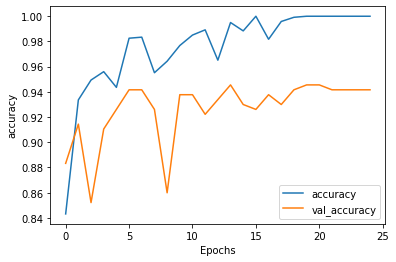

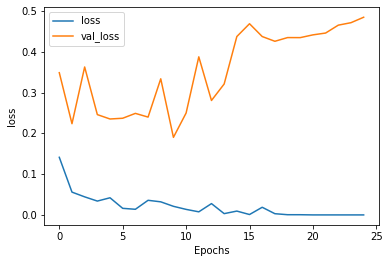

In [13]:
plotting(history, "accuracy")
plotting(history, "loss")

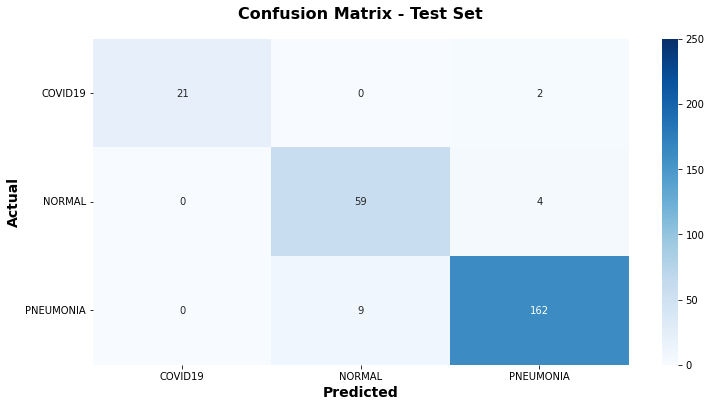

In [14]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [15]:
evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

257/257 [==============================] - 12s 45ms/step - loss: 0.4849 - accuracy: 0.9416
Test Accuracy: 94.16%
151/151 [==============================] - 35s 234ms/step - loss: 2.0949e-05 - accuracy: 1.0000
Train Accuracy: 100.00%


# Last Sample Size (60%)

## Processing

In [ ]:
train_path = "/content/drive/MyDrive/AY21_22/2021/BT4221/BT4221 Project/Processing   Model /Data/unique_60_sample_train"
test_path = "/content/drive/MyDrive/AY21_22/2021/BT4221/BT4221 Project/Processing   Model /Data/unique_60_sample_test"

In [ ]:
path = train_path
diag_code_dict = {
    'COVID19': 0,
    'NORMAL': 1,
    'PNEUMONIA': 2}

diag_title_dict = {
    'COVID19': 'Covid-19',
    'NORMAL': 'Healthy',
    'PNEUMONIA': 'Pneumonia'}

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}

imageid_path_dict

{}

In [ ]:
classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)

img_size = [224, 224]
train_datagen = ImageDataGenerator(rescale = 1./224)

test_datagen = ImageDataGenerator(rescale = 1./224)

train_generator = train_datagen.flow_from_directory(directory = train_path,
                                                        target_size = tuple(img_size),
                                                        batch_size = 8,
                                                        shuffle = True,
                                                        class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(directory = test_path,
                                                        target_size = tuple(img_size),
                                                        batch_size = 1,
                                                        class_mode = 'categorical',
                                                        shuffle = False)

Found 3618 images belonging to 3 classes.
Found 772 images belonging to 3 classes.


In [ ]:
num_pneumonia = len(os.listdir(os.path.join(train_path, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_path, 'NORMAL')))
num_covid = len(os.listdir(os.path.join(train_path, 'COVID19')))

total = num_normal + num_pneumonia + num_covid
weight_for_0 = num_covid / total
weight_for_1 = num_normal / total
weight_for_2 = num_pneumonia / total
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

## Model 3

In [ ]:
model =  MaxPooling2D(pool_size = (2, 2), 
                               strides = 1, padding = 'valid')(baseModel.output)
model = Flatten()(model)

model = Dense(units = 256, activation = 'relu')(model)
model = Dense(units = 128, activation = 'relu')(model)
model = Dense(units = 64, activation = 'relu')(model)


# Stick with 3 because 3 different classes to be predicted
predictions = Dense(units = 3, activation = 'softmax')(model)
model = Model(inputs = baseModel.input, outputs = predictions)

opt = Adam(learning_rate=0.001, decay=1e-6)
model.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15)
CheckPointCallback = ModelCheckpoint("vgg_60size.h5", monitor='val_accuracy',save_best_only=True, mode='max',verbose=1)

seed(1)
tensorflow.random.set_seed(2)

history = model.fit(train_generator,
                    epochs = 25,
                    batch_size = 16,
                    validation_data= test_generator,
                    class_weight = class_weight,
                    callbacks = [es, CheckPointCallback],
                    verbose = 1)

Epoch 1/25
453/453 [==============================] - 3105s 7s/step - loss: 0.0961 - accuracy: 0.8886 - val_loss: 0.1382 - val_accuracy: 0.9469

Epoch 00001: val_accuracy improved from -inf to 0.94689, saving model to vgg_60size.h5
Epoch 2/25
453/453 [==============================] - 137s 302ms/step - loss: 0.0428 - accuracy: 0.9469 - val_loss: 0.2817 - val_accuracy: 0.8925

Epoch 00002: val_accuracy did not improve from 0.94689
Epoch 3/25
453/453 [==============================] - 136s 301ms/step - loss: 0.0331 - accuracy: 0.9630 - val_loss: 0.1072 - val_accuracy: 0.9560

Epoch 00003: val_accuracy improved from 0.94689 to 0.95596, saving model to vgg_60size.h5
Epoch 4/25
453/453 [==============================] - 135s 297ms/step - loss: 0.0308 - accuracy: 0.9619 - val_loss: 0.0982 - val_accuracy: 0.9624

Epoch 00004: val_accuracy improved from 0.95596 to 0.96244, saving model to vgg_60size.h5
Epoch 5/25
453/453 [==============================] - 135s 297ms/step - loss: 0.0198 - accur

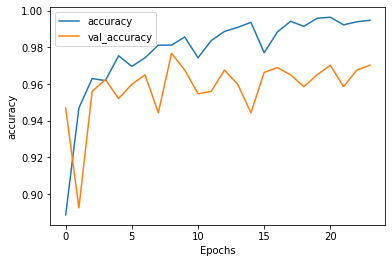

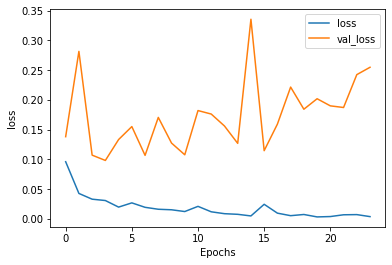

In [ ]:
plotting(history, "accuracy")
plotting(history, "loss")

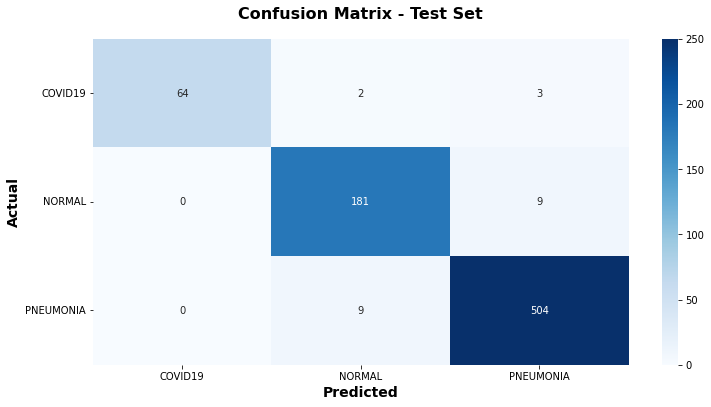

In [ ]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

772/772 [==============================] - 34s 43ms/step - loss: 0.2549 - accuracy: 0.9702
Test Accuracy: 97.02%
453/453 [==============================] - 106s 234ms/step - loss: 0.0051 - accuracy: 0.9981
Train Accuracy: 99.81%
